In [1]:
import glob
import numpy as np
from skimage import io
from skimage.transform import rescale
import re
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from math import sqrt
from skimage.filters import threshold_otsu
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
def get_data():
    files = glob.glob('data/hiragana73/*/*.png')
    m = len(files)
    print('Found %d files.' %m)
    
    return files

In [3]:
def create_data_array(files):
    X = np.array([io.imread(file, as_gray=True) for file in files])
    print('Data array created.')

    return X

In [4]:
def create_target_array(files):
    char_codes = files
    
    # Extract unicode from filepath
    i = 0
    for char_code in char_codes:
        code = re.search(r'[0-9]{3}[0-9A-F]', char_code)
        char_codes[i] = code.group(0)
        i += 1
        
    # Convert unicode to hiragana
    for i in range(len(char_codes)):
        char_codes[i] = chr(int(char_codes[i], 16))
        
    y = np.asarray(char_codes)
    
    # Encode to integers
    encoder = preprocessing.LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    
    print('Target array created.')
    
    return y

In [5]:
def reduce_dataset(X, y, reduced_size):
    '''
    Returns a stratified subsample of the dataset
    X, y reduced in size by (1 - reduced size).
    Can be used to save CPU time if you only need to
    perform quick experiments on a smaller dataset.
    '''
    
    X_discard, X, y_discard, y = train_test_split(X, y, test_size=reduced_size, stratify=y)
    print('Reduced dataset to %d%% of original size.' %(reduced_size*100))
    
    return X, y

In [6]:
def clean_data(X):
    # Rescaled images need new array
    m = X.shape[0] # Number of examples
    rescale_factor = 0.5
    image_side_new = int(X.shape[1] * rescale_factor)
    X_new = np.zeros(shape=(m, image_side_new, image_side_new))
    
    # Rescale and binarise (make black-and-white)
    for i in range(m):
        image = X[i]
        image = rescale(image, scale=rescale_factor)
        thresh = threshold_otsu(image)
        image = image > thresh
        X_new[i] = image        
        
    # Flatten for sklearn
    X_new = X_new.reshape(m, -1)
    
    print('Data cleaned.')
    
    return X_new

In [7]:
def train(X, y):
    print('Train on %d samples.' %(X.shape[0]))

    image_shape = X.shape[1:]
    n_feaures = np.prod(X.shape[1:])
    n_classes = len(set(y))
    hidden_layer_size = int(sqrt(n_feaures*n_classes))
    
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=image_shape),
        keras.layers.Dense(hidden_layer_size, activation='relu'),
        keras.layers.Dense(n_classes)
    ])
        
    model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

    history = model.fit(X, y, epochs=10, verbose=0, validation_split=0.1)
    
    return model, history

In [18]:
def evaluate(history):
    #print(history.history)
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def run():
    files = get_data()
    X = create_data_array(files)
    y = create_target_array(files)
    X, y = reduce_dataset(X, y, reduced_size=0.1)
    X = clean_data(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    model = train(X_train, y_train)
    test(X_test, y_test, model)

run()

In [9]:
files = get_data()
X = create_data_array(files)
y = create_target_array(files)
X, y = reduce_dataset(X, y, reduced_size=0.1)
X = clean_data(X)

Found 80000 files.
Data array created.
Target array created.
Reduced dataset to 10% of original size.
Data cleaned.


In [10]:
model, history = train(X, y)

Train on 8000 samples.


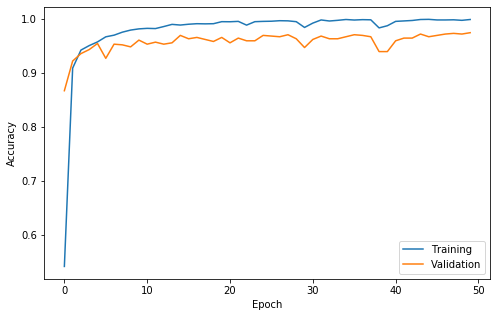

In [19]:
evaluate(history)